```
Copyright 2020 The IREE Authors

Licensed under the Apache License v2.0 with LLVM Exceptions.
See https://llvm.org/LICENSE.txt for license information.
SPDX-License-Identifier: Apache-2.0 WITH LLVM-exception
```


# Image edge detection module

## Setup

In [1]:
!python -m pip install iree-compiler-snapshot iree-runtime-snapshot iree-tools-tf-snapshot -f https://github.com/google/iree/releases

Looking in links: https://github.com/google/iree/releases
     |████████████████████████████████| 33.2MB 121kB/s 
     |████████████████████████████████| 532kB 49.9MB/s 
     |████████████████████████████████| 52.1MB 90kB/s 


In [2]:
#@title Imports

import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from iree import runtime as ireert
from iree.tf.support import module_utils
from iree.compiler import compile_str
from iree.compiler import tf as tfc

In [3]:
#@title Setup Artifacts Directory

# Used in the low-level compilation section.
ARTIFACTS_DIR = os.path.join(tempfile.gettempdir(), "iree", "colab_artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

In [4]:
#@title Define the EdgeDetectionModule
class EdgeDetectionModule(tf.Module):

  @tf.function(input_signature=[tf.TensorSpec([1, 128, 128, 1], tf.float32)])
  def edge_detect_sobel_operator(self, image):
    # https://en.wikipedia.org/wiki/Sobel_operator
    sobel_x = tf.constant([[-1.0, 0.0, 1.0],
                           [-2.0, 0.0, 2.0],
                           [-1.0, 0.0, 1.0]],
                          dtype=tf.float32, shape=[3, 3, 1, 1])    
    sobel_y = tf.constant([[ 1.0,  2.0,  1.0],
                           [ 0.0,  0.0,  0.0],
                           [-1.0, -2.0, -1.0]],
                          dtype=tf.float32, shape=[3, 3, 1, 1])
    gx = tf.nn.conv2d(image, sobel_x, 1, "SAME")
    gy = tf.nn.conv2d(image, sobel_y, 1, "SAME")
    return tf.math.sqrt(gx * gx + gy * gy)

tf_module = EdgeDetectionModule()

90112/83281 [================================] - 0s 0us/step


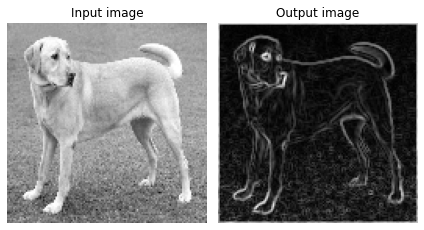

In [5]:
#@title Load a test image of a [labrador](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) and run the module with TF
def load_image(path_to_image):
  image = tf.io.read_file(path_to_image)
  image = tf.image.decode_image(image, channels=1)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (128, 128))
  image = image[tf.newaxis, :]
  return image

content_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image = load_image(content_path).numpy()

def show_images(image, edges):
  fig, axs = plt.subplots(1, 2)

  axs[0].imshow(image.reshape(128, 128), cmap="gray")
  axs[0].set_title("Input image")
  axs[1].imshow(edges.reshape(128, 128), cmap="gray")
  axs[1].set_title("Output image")

  axs[0].axis("off")
  axs[1].axis("off")
  fig.tight_layout()
  fig.show()

# Invoke the function with the image as an argument
tf_edges = tf_module.edge_detect_sobel_operator(image).numpy()

# Plot the input and output images
show_images(image, tf_edges)

## High Level Compilation With IREE

In [6]:
#@markdown ### Backend Configuration

backend_choice = "iree_vmvx (CPU)" #@param [ "iree_vmvx (CPU)", "iree_llvmaot (CPU)", "iree_vulkan (GPU/SwiftShader)" ]
backend_choice = backend_choice.split(" ")[0]
backend = module_utils.BackendInfo(backend_choice)

INFO:tensorflow:Assets written to: /tmp/tmp173tk864.sm/assets


2021-06-04 16:34:58.905213: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:37] Reading SavedModel from: /tmp/tmp173tk864.sm
2021-06-04 16:34:58.905584: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:60] Reading SavedModel debug info (if present) from: /tmp/tmp173tk864.sm
2021-06-04 16:34:58.926014: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Created IREE driver vmvx: <iree.runtime.binding.HalDriver object at 0x7f6cc5e38ef0>
SystemContext driver=<iree.runtime.binding.HalDriver object at 0x7f6cc5e38ef0>


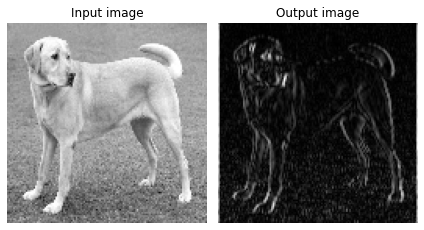

In [7]:
#@title Compile and Run the EdgeDetectionModule with IREE.
module = backend.compile_from_class(EdgeDetectionModule)

# Compute the edges using the compiled module and display the result.
iree_edges = module.edge_detect_sobel_operator(image)
show_images(image, iree_edges)

## Low-Level Compilation

Overview:

1.  Convert the `tf.Module` into an IREE compiler module (using `mhlo`)
2.  Save the MLIR assembly from the module into a file (can stop here to use it from another application)
3.  Compile the `mhlo` MLIR into a VM module for IREE to execute
4.  Run the VM module through IREE's runtime to test the edge detection function

In [8]:
#@title Construct a module containing the edge detection function

# Do *not* further compile to a bytecode module for a particular backend.
# 
# By stopping at mhlo in text format, we can more easily take advantage of
# future compiler improvements within IREE and can use iree_bytecode_module to
# compile and bundle the module into a sample application. For a production
# application, we would probably want to freeze the version of IREE used and
# compile as completely as possible ahead of time, then use some other scheme
# to load the module into the application at runtime.
compiler_module = tfc.compile_module(EdgeDetectionModule(), import_only=True)
print("Edge Detection MLIR: ", compiler_module.decode('utf-8'))

edge_detection_mlir_path = os.path.join(ARTIFACTS_DIR, "edge_detection.mlir")
with open(edge_detection_mlir_path, "wt") as output_file:
  output_file.write(compiler_module.decode('utf-8'))
print(f"Wrote MLIR to path '{edge_detection_mlir_path}'")

INFO:tensorflow:Assets written to: /tmp/tmp247st3qi.sm/assets
Edge Detection MLIR:  #loc0 = loc(unknown)
module  {
  func @edge_detect_sobel_operator(%arg0: tensor<1x128x128x1xf32> {tf._user_specified_name = "image"} loc(unknown)) -> tensor<1x128x128x1xf32> attributes {iree.module.export, iree.reflection = {abi = "sip", abiv = 1 : i32, sip = "I8!S5!k0_0R3!_0"}, tf._construction_context = "kEagerRuntime", tf._input_shapes = [#tf.shape<1x128x128x1>]} {
    %0 = mhlo.constant dense<[[[[-1.000000e+00]], [[0.000000e+00]], [[1.000000e+00]]], [[[-2.000000e+00]], [[0.000000e+00]], [[2.000000e+00]]], [[[-1.000000e+00]], [[0.000000e+00]], [[1.000000e+00]]]]> : tensor<3x3x1x1xf32> loc(#loc1)
    %1 = mhlo.constant dense<[[[[1.000000e+00]], [[2.000000e+00]], [[1.000000e+00]]], [[[0.000000e+00]], [[0.000000e+00]], [[0.000000e+00]]], [[[-1.000000e+00]], [[-2.000000e+00]], [[-1.000000e+00]]]]> : tensor<3x3x1x1xf32> loc(#loc2)
    %2 = mhlo.convolution(%arg0, %0) dim_numbers = [b, 0, 1, f]x[0, 1, i, o

2021-06-04 16:34:59.529912: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:37] Reading SavedModel from: /tmp/tmp247st3qi.sm
2021-06-04 16:34:59.530488: I external/org_tensorflow/tensorflow/cc/saved_model/bundle_v2.cc:60] Reading SavedModel debug info (if present) from: /tmp/tmp247st3qi.sm
2021-06-04 16:34:59.552411: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#@title Compile and prepare to test the edge detection module

flatbuffer_blob = compile_str(compiler_module, target_backends=["vmvx"])
vm_module = ireert.VmModule.from_flatbuffer(flatbuffer_blob)

# Register the module with a runtime context.
config = ireert.Config(backend.driver)
ctx = ireert.SystemContext(config=config)
ctx.add_vm_module(vm_module)

Created IREE driver vmvx: <iree.runtime.binding.HalDriver object at 0x7f6d1b6f75b0>
SystemContext driver=<iree.runtime.binding.HalDriver object at 0x7f6d1b6f75b0>


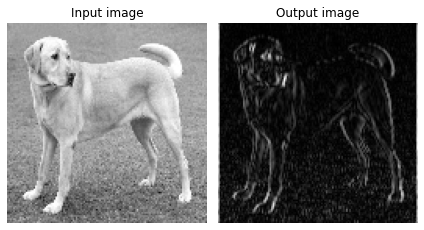

In [10]:
edge_detect_sobel_operator_f = ctx.modules.module["edge_detect_sobel_operator"]

low_level_iree_edges = edge_detect_sobel_operator_f(image)

show_images(image, low_level_iree_edges)